## Download Data with Kaggle API and Install Libraries

Upload your kaggle.json to directory to download the data or download here [aged-synthetic-dataset](https://www.kaggle.com/datasets/penpentled/aged-synthetic-images)

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d penpentled/aged-synthetic-images
!unzip /content/aged-synthetic-images.zip -d /content/

 56% 5.23G/9.29G [01:03<00:34, 127MB/s]

In [ ]:
!pip install piq kornia pytorch-lightning

# Making Dataset

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import kornia

from torch.utils.data import Dataset, DataLoader

from PIL import Image
import pandas as pd
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

import random
from itertools import permutations
from tqdm import tqdm

In [ ]:
TARGET_AGES = [18,23,28,33,38,43,48,53,58,63,68,73,78,83]
DATA_DIR = '/content/synthetic_images/'

In [ ]:
class FRANDataset(Dataset):
  def __init__(self, image_pairs, image_ages_dict, transforms, transform_resize):
    self.image_pairs = image_pairs
    self.image_ages_dict = image_ages_dict
    self.transforms = transforms
    self.transform_resize = transform_resize

  def __len__(self):
    return len(self.image_pairs)

  def __getitem__(self, index):
    image_pair = self.image_pairs[index]

    input_image = np.array(Image.open(DATA_DIR+image_pair[0]).convert('RGB'))
    target_image = np.array(Image.open(DATA_DIR+image_pair[1]).convert('RGB'))

    normalized_input_image_transformed = self.transforms(image=input_image)
    normalized_input_image = normalized_input_image_transformed['image']/127.5 - 1

    normalized_target_image = A.ReplayCompose.replay(normalized_input_image_transformed['replay'], image=np.array(target_image))['image']/127.5 - 1

    rgb_delta = normalized_target_image - normalized_input_image

    # Get age maps
    _,width,height=normalized_input_image.shape
    age_map1 = torch.full((1,width,height),self.image_ages_dict[image_pair[0]]/100)
    age_map2 = torch.full((1,width,height),self.image_ages_dict[image_pair[1]]/100)

    # Combine RGB delta diff with age maps for 5-channel tensor
    input_tensor = torch.cat((normalized_input_image, age_map1, age_map2), dim=0)

    return {
        'input': input_tensor,
        'normalized_input_image': normalized_input_image,
        'normalized_target_image': normalized_target_image,
        'target_age': age_map2,
      }

In [ ]:
# Some augmentations
transform_normalize = A.ReplayCompose([
    A.Resize(512, 512),
    A.RandomCrop(256, 256),
    A.ColorJitter(p=0.8),
    A.Blur(p=0.1),
    A.RandomBrightnessContrast(),
    A.Affine(rotate=[-30, 30],scale=(0.5,1.5), p=0.8),
    ToTensorV2(),
])


transform_resize = A.Compose([
    A.Resize(512, 512),
    ToTensorV2(),
])

In [ ]:
image_meta = pd.read_csv('/content/image_meta.csv')

In [ ]:
image_meta

image_18                     image_23  \
0     aged_images/18_seed0002.png  aged_images/23_seed0002.png   
1     aged_images/18_seed0003.png  aged_images/23_seed0003.png   
2     aged_images/18_seed0004.png  aged_images/23_seed0004.png   
3     aged_images/18_seed0005.png  aged_images/23_seed0005.png   
4     aged_images/18_seed0006.png  aged_images/23_seed0006.png   
...                           ...                          ...   
1995  aged_images/18_seed1997.png  aged_images/23_seed1997.png   
1996  aged_images/18_seed1998.png  aged_images/23_seed1998.png   
1997  aged_images/18_seed1999.png  aged_images/23_seed1999.png   
1998  aged_images/18_seed2000.png  aged_images/23_seed2000.png   
1999  aged_images/18_seed2001.png  aged_images/23_seed2001.png   

                         image_28                     image_33  \
0     aged_images/28_seed0002.png  aged_images/33_seed0002.png   
1     aged_images/28_seed0003.png  aged_images/33_seed0003.png   
2     aged_images/28_seed0004.png  aged_images/33_seed0004.png   
3     aged_images/28_seed0005.png  aged_images/33_seed0005.png   
4     aged_images/28_seed0006.png  aged_images/33_seed0006.png   
...                           ...                          ...   
1995  aged_images/28_seed1997.png  aged_images/33_seed1997.png   
1996  aged_images/28_seed1998.png  aged_images/33_seed1998.png   
1997  aged_images/28_seed1999.png  aged_images/33_seed1999.png   
1998  aged_images/28_seed2000.png  aged_images/33_seed2000.png   
1999  aged_images/28_seed2001.png  aged_images/33_seed2001.png   

                         image_38                     image_43  \
0     aged_images/38_seed0002.png  aged_images/43_seed0002.png   
1     aged_images/38_seed0003.png  aged_images/43_seed0003.png   
2     aged_images/38_seed0004.png  aged_images/43_seed0004.png   
3     aged_images/38_seed0005.png  aged_images/43_seed0005.png   
4     aged_images/38_seed0006.png  aged_images/43_seed0006.png   
...                           ...                          ...   
1995  aged_images/38_seed1997.png  aged_images/43_seed1997.png   
1996  aged_images/38_seed1998.png  aged_images/43_seed1998.png   
1997  aged_images/38_seed1999.png  aged_images/43_seed1999.png   
1998  aged_images/38_seed2000.png  aged_images/43_seed2000.png   
1999  aged_images/38_seed2001.png  aged_images/43_seed2001.png   

                         image_48                     image_53  \
0     aged_images/48_seed0002.png  aged_images/53_seed0002.png   
1     aged_images/48_seed0003.png  aged_images/53_seed0003.png   
2     aged_images/48_seed0004.png  aged_images/53_seed0004.png   
3     aged_images/48_seed0005.png  aged_images/53_seed0005.png   
4     aged_images/48_seed0006.png  aged_images/53_seed0006.png   
...                           ...                          ...   
1995  aged_images/48_seed1997.png  aged_images/53_seed1997.png   
1996  aged_images/48_seed1998.png  aged_images/53_seed1998.png   
1997  aged_images/48_seed1999.png  aged_images/53_seed1999.png   
1998  aged_images/48_seed2000.png  aged_images/53_seed2000.png   
1999  aged_images/48_seed2001.png  aged_images/53_seed2001.png   

                         image_58                     image_63  \
0     aged_images/58_seed0002.png  aged_images/63_seed0002.png   
1     aged_images/58_seed0003.png  aged_images/63_seed0003.png   
2     aged_images/58_seed0004.png  aged_images/63_seed0004.png   
3     aged_images/58_seed0005.png  aged_images/63_seed0005.png   
4     aged_images/58_seed0006.png  aged_images/63_seed0006.png   
...                           ...                          ...   
1995  aged_images/58_seed1997.png  aged_images/63_seed1997.png   
1996  aged_images/58_seed1998.png  aged_images/63_seed1998.png   
1997  aged_images/58_seed1999.png  aged_images/63_seed1999.png   
1998  aged_images/58_seed2000.png  aged_images/63_seed2000.png   
1999  aged_images/58_seed2001.png  aged_images/63_seed2001.png   

                         image_68                     image_

In [ ]:
# generate image age pairs
image_pairs = []

for _, row in image_meta.iterrows():
    image_paths = row.tolist()  # Convert the row to a list of image paths
    image_combinations = permutations(image_paths, 2)
    image_pairs.extend(list(image_combinations))

image_pairs[:5]

[('aged_images/18_seed0002.png', 'aged_images/23_seed0002.png'),
 ('aged_images/18_seed0002.png', 'aged_images/28_seed0002.png'),
 ('aged_images/18_seed0002.png', 'aged_images/33_seed0002.png'),
 ('aged_images/18_seed0002.png', 'aged_images/38_seed0002.png'),
 ('aged_images/18_seed0002.png', 'aged_images/43_seed0002.png')]

In [ ]:
# generate image age dict {image path:age}
image_age_dict={}
for target_age, column in zip(TARGET_AGES,image_meta.columns):
  image_age_dict.update({path:target_age for path in image_meta[column].values})

# Modeling

In [ ]:
class BlurUpSample(nn.Module):
    def __init__(self, c):
        super(BlurUpSample, self).__init__()
        self.blurpool =  kornia.filters.GaussianBlur2d((3, 3), (1.5, 1.5))
        self.upsample = nn.Upsample(scale_factor=(2, 2), mode='bilinear', align_corners=False)

    def forward(self, x):
        x = self.blurpool(x)
        x = self.upsample(x)

        return x

class DownLayer(nn.Module):
    def __init__(self, c_in, c_out):
        super(DownLayer, self).__init__()
        self.maxblurpool = kornia.filters.MaxBlurPool2D(kernel_size=3)
        self.conv1 = nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(c_out)
        self.leakyrelu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(c_out)

    def forward(self, x):
        x = self.maxblurpool(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leakyrelu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leakyrelu(x)
        return x


class UpLayer(nn.Module):
    def __init__(self, c_in, c_out):
        super(UpLayer, self).__init__()
        self.upsample = BlurUpSample(c_in)
        self.conv1 = nn.Conv2d(c_in+ c_out, c_out, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(c_out)
        self.leakyrelu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(c_out)

    def forward(self, x, skip_x):
        x = self.upsample(x)

        dh = skip_x.size(2) - x.size(2)
        dw = skip_x.size(3) - x.size(3)

        x = F.pad(x, (dw // 2, dw - dw // 2, dh // 2, dh - dh // 2))

        x = torch.cat([x, skip_x], dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leakyrelu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leakyrelu(x)
        return x

In [ ]:
# FRAN Unet Model
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.conv1 = nn.Conv2d(5, 64, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.batchnorm1 = nn.BatchNorm2d(64)
    self.leakyrelu = nn.LeakyReLU(inplace=True)
    self.downlayer1 = DownLayer(64, 128)
    self.downlayer2 = DownLayer(128, 256)
    self.downlayer3 = DownLayer(256, 512)
    self.downlayer4 = DownLayer(512, 1024)
    self.uplayer1 = UpLayer(1024, 512)
    self.uplayer2 = UpLayer(512, 256)
    self.uplayer3 = UpLayer(256, 128)
    self.uplayer4 = UpLayer(128, 64)
    self.conv3 = nn.Conv2d(64, 3, kernel_size=1, stride=1, padding=0)

  def forward(self, x):
    #print(f'Input Shape: {x.shape}')
    x1 = self.conv1(x)
    x1 = self.batchnorm1(x1)
    x1 = self.leakyrelu(x1)
    x1 = self.conv2(x1)
    x1 = self.batchnorm1(x1)
    x1 = self.leakyrelu(x1)

    #print(f'Processed Input Shape: {x.shape}')

    x2 = self.downlayer1(x1)
    x3 = self.downlayer2(x2)
    x4 = self.downlayer3(x3)
    x5 = self.downlayer4(x4)

    #print(f'Done Downlayering... Shape: {x5.shape}')

    x = self.uplayer1(x5, x4)
    x = self.uplayer2(x, x3)
    x = self.uplayer3(x, x2)
    x = self.uplayer4(x, x1)
    x = self.conv3(x)

    #print(f'Output Shape: {x.shape}')
    return x

In [ ]:
class PatchGANDiscriminator(nn.Module):
    def __init__(self):
        super(PatchGANDiscriminator, self).__init__()
        self.conv0 = nn.Conv2d(4, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.leakyrelu = nn.LeakyReLU(inplace=True)
        self.maxblurpool = kornia.filters.MaxBlurPool2D(kernel_size=3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.conv0(x)
        x = self.bn1(x)
        x = self.leakyrelu(x)
        x = self.maxblurpool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leakyrelu(x)
        x = self.maxblurpool(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.leakyrelu(x)
        x = self.maxblurpool(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.leakyrelu(x)
        x = self.conv5(x)

        return x

# Training Model

In [ ]:
import torchvision.models as models
import torch.optim as optim
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from piq import LPIPS

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
dataset = FRANDataset(image_pairs, image_age_dict, transform_normalize=transform_normalize, transform_resize=transform_resize)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

In [ ]:
from torch.nn.modules import BCEWithLogitsLoss
# Define losses
adversarial_loss = BCEWithLogitsLoss()
l1_loss = nn.L1Loss()
perceptual_loss = LPIPS().to(device)

In [ ]:
lambda_l1 = 1
lambda_perceptual = 1
lambda_adversarial = 0.05

In [ ]:
# Basic pl lightning module for checkpointing and logging
class FRAN(pl.LightningModule):
  def __init__(self, generator, discriminator):
    super(FRAN, self).__init__()
    self.generator = generator
    self.discriminator =discriminator
    self.automatic_optimization = False
    self.my_step =0

  def forward(self, x):
      with torch.no_grad():
        model_output = self.generator(x)
      return model_output

  def training_step(self, batch, batch_idx):
      opt_g, opt_d = self.optimizers()

      opt_g.zero_grad()
      opt_d.zero_grad()


      inputs = batch['input'].to(self.device)
      normalized_input_image = batch['normalized_input_image'].to(self.device)
      normalized_target_image = batch['normalized_target_image'].to(self.device)


      target_age = batch['target_age'].to(self.device)
      # Forward pass
      outputs = self.generator(inputs)

      predicted_images = normalized_input_image+outputs
      predicted_images_with_age = torch.cat((predicted_images, target_age), dim=1)

      real_labels = torch.ones(inputs.shape[0], 1, 32, 32).to(self.device)
      fake_labels = torch.zeros(inputs.shape[0], 1, 32, 32).to(self.device)

      # Compute discriminator losses
      real_loss = adversarial_loss(self.discriminator(torch.cat((normalized_target_image, target_age), dim=1)), real_labels)
      fake_loss = adversarial_loss(self.discriminator(predicted_images_with_age.detach()), fake_labels)

      d_loss = (real_loss+fake_loss) / 2

      self.manual_backward(d_loss)
      opt_d.step()

      # Compute generator loss
      l1_loss_value = l1_loss(predicted_images, normalized_target_image)
      perceptual_loss_value = perceptual_loss(predicted_images, normalized_target_image)
      adversarial_loss_value = adversarial_loss(self.discriminator(predicted_images_with_age), real_labels)

      total_loss =  lambda_adversarial*adversarial_loss_value+ lambda_perceptual*perceptual_loss_value + lambda_l1*l1_loss_value

      self.manual_backward(total_loss)
      opt_g.step()

      # Log loss
      self.log('fake_loss', fake_loss, prog_bar=True)
      self.log('discriminator_loss', d_loss, prog_bar=True)
      self.log('total_loss', total_loss, prog_bar=True)
      self.log('gen_adversarial_loss', lambda_adversarial*adversarial_loss_value, prog_bar=True)
      self.log('perceptual_loss', perceptual_loss_value.mean()*lambda_perceptual, prog_bar=True)
      self.log('l1_loss', l1_loss_value*lambda_l1, prog_bar=True)

      # Display images every 500 steps
      if self.my_step % 100 == 0:

        sample_image = inputs[0]
        model_output = outputs.detach()

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 5, 1)
        plt.imshow(((normalized_input_image[0].cpu().permute(1,2,0).numpy()+1)*127.5).astype('uint'))
        plt.title(f"Input Image, Age: {int(sample_image[3][0][0]*100)}")
        plt.axis('off')

        plt.subplot(1, 5, 2)
        plt.imshow(((normalized_target_image[0].cpu().permute(1,2,0).numpy()+1)*127.5).astype('uint'))
        plt.title("Target Image")
        plt.axis('off')

        new_image = (((normalized_input_image[0].cpu()+model_output[0].cpu()).permute(1,2,0).numpy()+1)*127.5).astype('uint')
        plt.subplot(1, 5, 3)
        plt.imshow(new_image)
        plt.title(f"Output Image, Age: {int(sample_image[4][0][0]*100)}")
        plt.axis('off')

        new_image = (((torch.abs(normalized_target_image[0].cpu()-normalized_input_image[0].cpu())).permute(1,2,0).numpy()+1)*127.5).astype('uint')
        plt.subplot(1, 5, 4)
        plt.imshow(new_image)
        plt.title(f"Tar RGB Diff")
        plt.axis('off')

        new_image = (((torch.abs(model_output[0].cpu())).permute(1,2,0).numpy()+1)*127.5).astype('uint')
        plt.subplot(1, 5, 5)
        plt.imshow(new_image)
        plt.title(f"Pred RGB Diff")
        plt.axis('off')

        plt.show()

      self.my_step +=1

  def configure_optimizers(self):
    generator_optimizer = optim.Adam(self.generator.parameters(), lr=0.0001)
    discriminator_optimizer = optim.Adam(self.discriminator.parameters(), lr=0.0001)

    return [generator_optimizer, discriminator_optimizer]

In [ ]:
fran_model = FRAN(Generator(), PatchGANDiscriminator())

In [ ]:
fran_trainer = pl.Trainer(
  precision='16-mixed',
devices=1,
  max_epochs=20,
  callbacks =[ pl.callbacks.ModelCheckpoint(
    every_n_train_steps=5000,
    dirpath='/content/age-model-checkpoints/',
    filename='fran-{step:05d}',
  )]
)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type                  | Params
--------------------------------------------------------
0 | generator     | Generator             | 31.4 M
1 | discriminator | PatchGANDiscriminator | 1.6 M 
--------------------------------------------------------
32.9 M    Trainable params
0         Non-trainable params
32.9 M    Total params
131.800   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

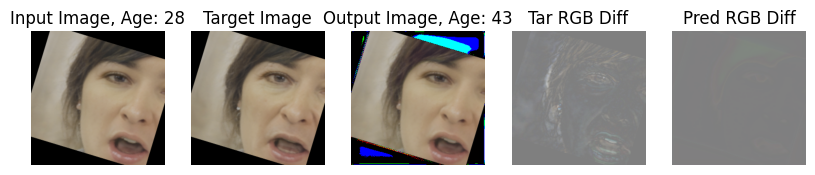

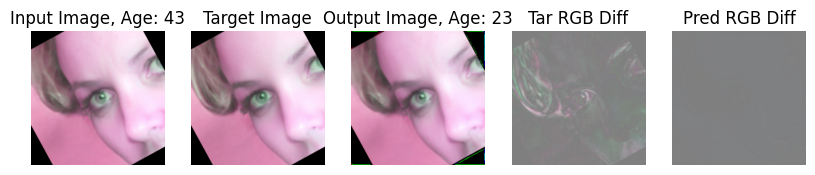

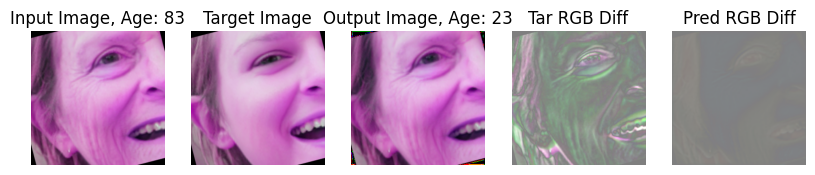

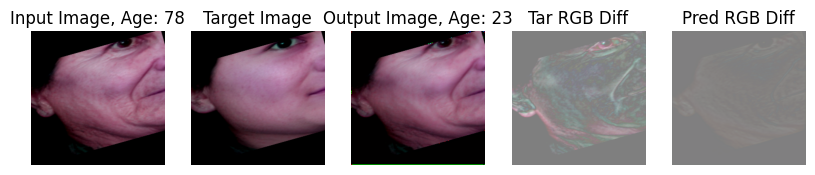

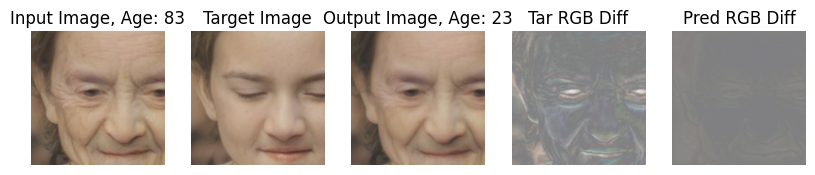

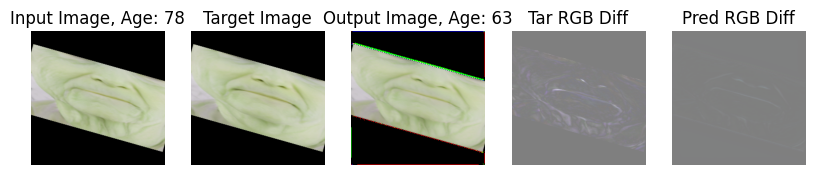

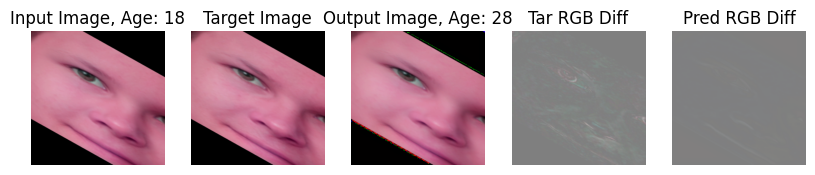

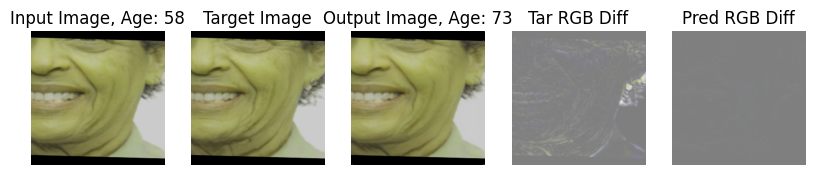

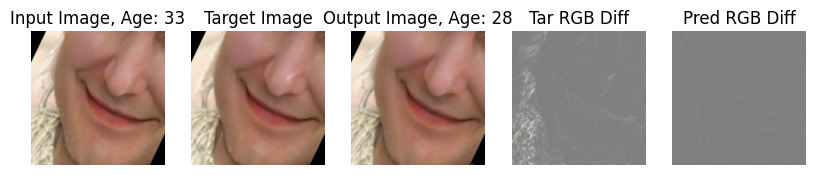

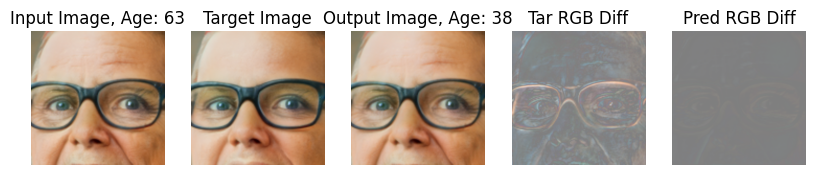

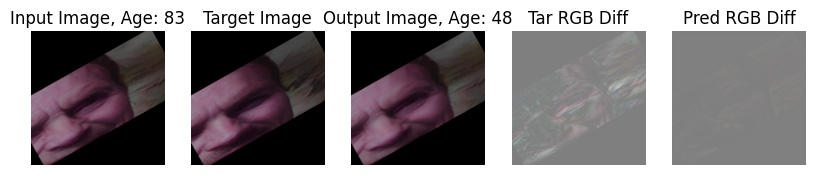

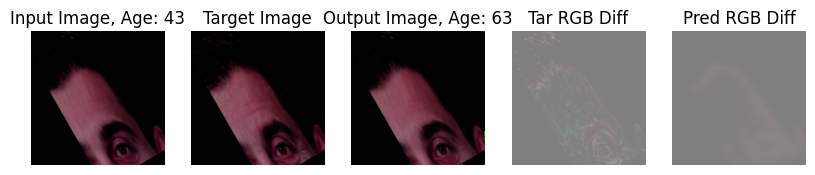

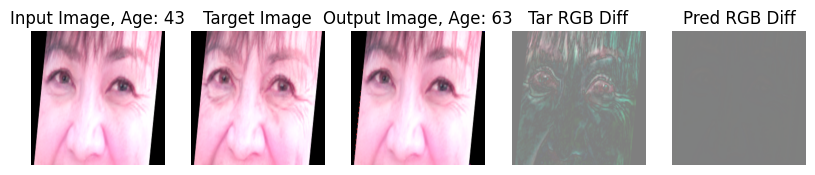

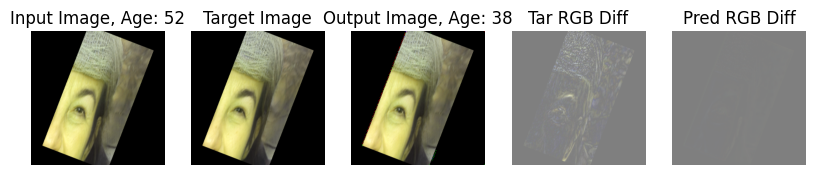

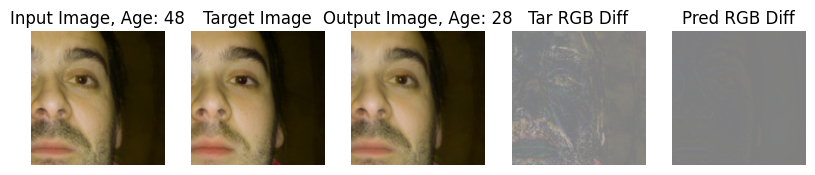

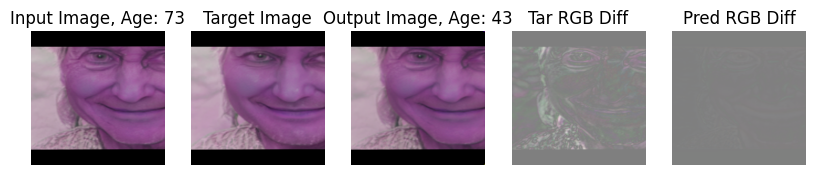

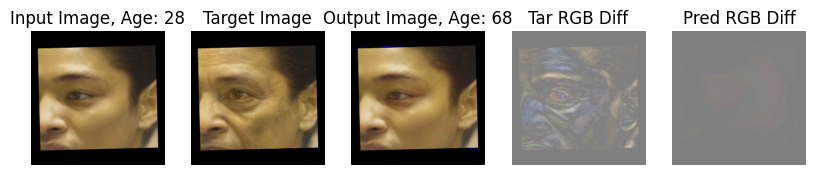

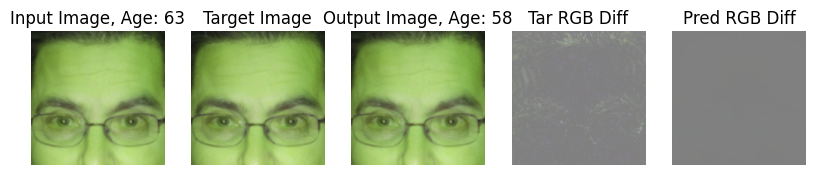

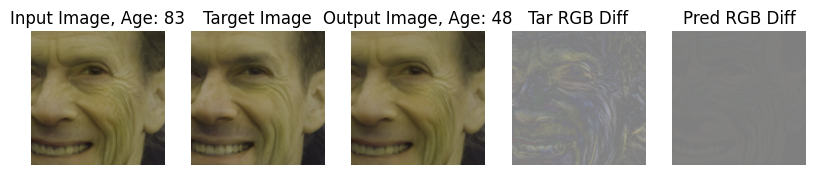

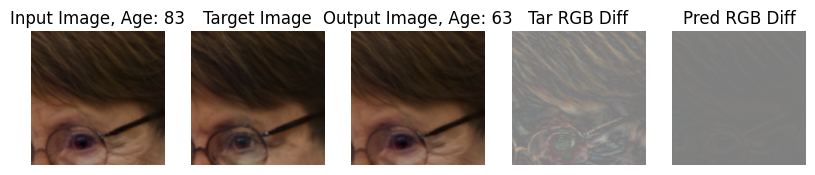

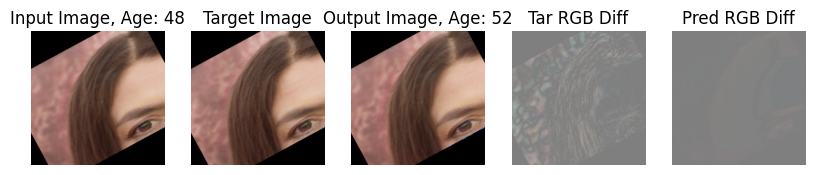

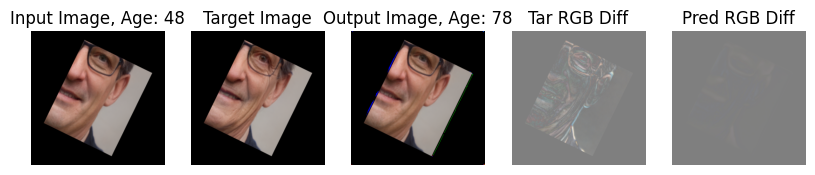

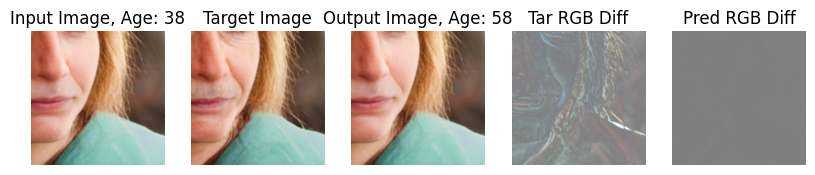

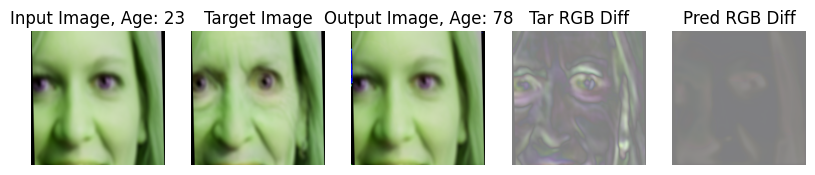

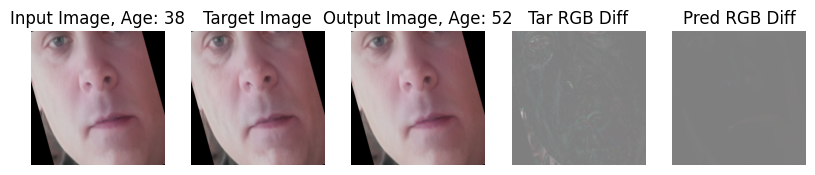

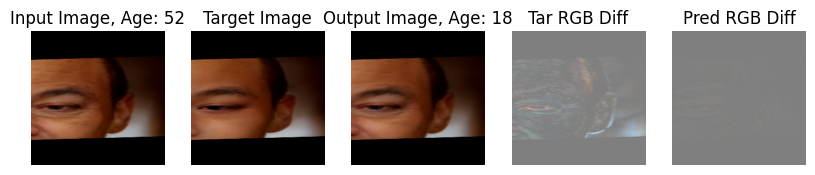

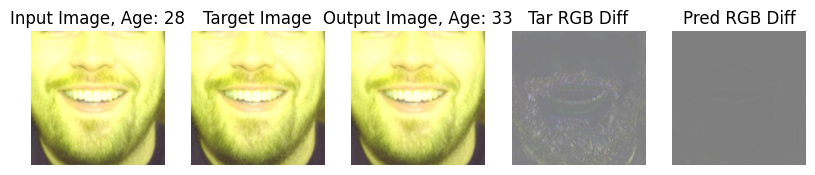

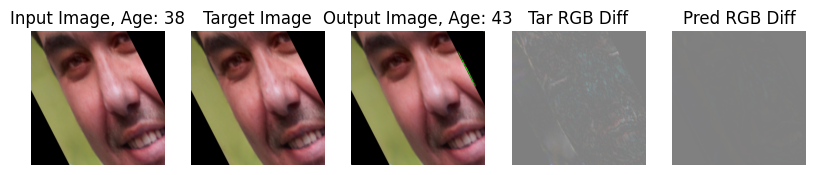

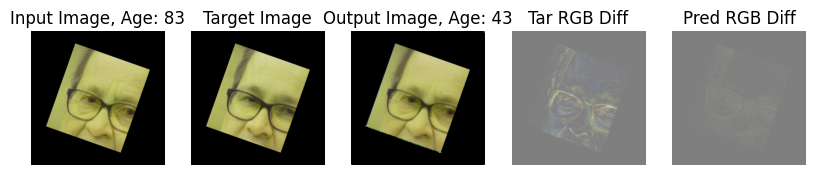

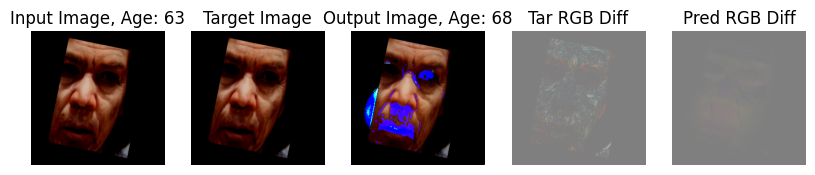

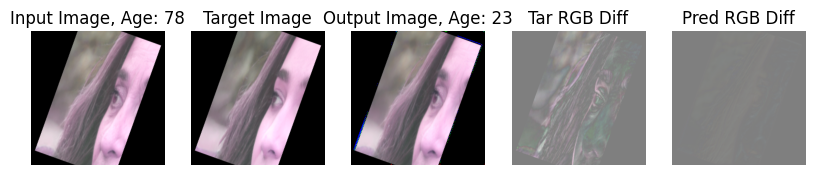

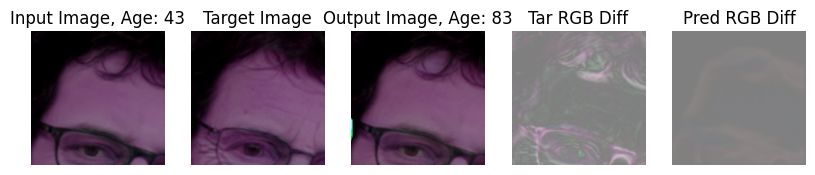

In [ ]:
fran_trainer.fit(fran_model, dataloader)

Ended training early. Ideally, train for over 3 epochs.

# Demo

Simple Demo: Crop out face and run the image through the model. https://huggingface.co/spaces/penpen/age-transformation  